This notebook reproduces the parametric sensitivity results in the paper

"Evaluating Sensitivity to the Stick Breaking Prior in Bayesian Nonparametrics"
https://arxiv.org/abs/1810.06587


It loads the model fits from './iris_fits/', so make sure to run the notebook `fit_base_model.ipynb` first. 

In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
sys.path.insert(0, '../../libraries/')
import gmm_clustering_lib as gmm_lib
import modeling_lib 
import utils_lib
import cluster_quantities_lib as cluster_lib
import optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

from tqdm import tqdm

/home/runjing_liu/Documents/BNP/autograd/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

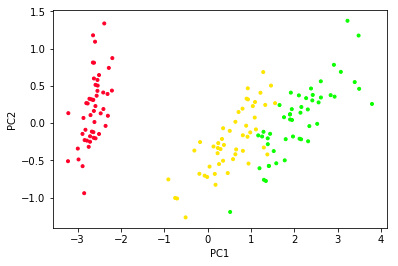

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

In [4]:
def assert_optimizer(features, vb_opt_dict, vb_params_paragami, prior_params_dict, gh_loc, gh_weights): 
    # this function checks that vb_opt_dict are at a kl optimum for the given 
    # prior parameters
    
    get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
    get_vb_params_loss.cache_args(features, None, prior_params_dict,
                                    gh_loc, gh_weights)
    get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                            patterns=vb_params_paragami,
                                            free=True)
    grad_get_loss = autograd.grad(get_loss)
    linf_grad = np.max(np.abs(grad_get_loss(vb_params_paragami.flatten(vb_opt_dict, free = True))))
    
    assert  linf_grad < 1e-5, 'error: {}'.format(linf_grad)


In [5]:
def get_linear_sensitivity_results(init_alpha, alpha_list, threshold = 0, insample = True):

    """
    Returns the data necessary to recreate the parametric sensitivity figures
    
    Parameters
    ----------
    init_alpha : float
        The alpha parameter at which to compute the linear response
    alpha_list : vector
        Vector of the alphas to which we will extrapolate
    threshold : int
        Miniumum number of observations for a cluster to be counted.
        and returns the gradient of get_loss.
    insample : boolean
        Whether to compute the in-sample quantity or the predictive quantity 

    Returns
    -------
    lr_e_num_clusters_vec : vec
        Vector of expected number of clusters computed by the linear approximation at the alphas in alpha_list
    refit_e_num_clusters_vec : vec
        Vector of expected number of clusters computed by the refitting at the alphas in alpha_list
    """

    
    # load optimal vb parameters at init_alpha
    vb_opt_dict, vb_params_paragami, data =\
        paragami.load_folded('./iris_fits/iris_fits_alpha{}.npz'.format(init_alpha))
    
    # free optimal vb_parameters
    vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)
    
    # load prior parameters
    prior_params_dict, prior_params_paragami = \
        gmm_lib.get_default_prior_params(dim = vb_opt_dict['centroids'].shape[0])
    prior_params_dict['alpha'] = data['alpha']
    
    
    # other parameters
    gh_deg = int(data['gh_deg'])
    gh_loc, gh_weights = hermgauss(gh_deg)
    
    # assert we are at an optimum 
    assert_optimizer(features, vb_opt_dict, vb_params_paragami, prior_params_dict, gh_loc, gh_weights)
    
    # get linear sensitivity 
    get_prior_vb_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=[1, 2])

    get_prior_vb_loss.cache_args(features, None, None, gh_loc, gh_weights)
    
    print('computing linear approximation at alpha = {}'.format(init_alpha))
    vb_sens = paragami.HyperparameterSensitivityLinearApproximation(
                    objective_fun=           get_prior_vb_loss,
                    opt_par_pattern=         vb_params_paragami,
                    hyper_par_pattern=       prior_params_paragami,
                    opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
                    hyper_par_folded_value=  prior_params_dict,
                    opt_par_is_free=         True,
                    hyper_par_is_free=       False,
                    grad_tol=                1e-5)
    
    lr_e_num_clusters_vec = np.zeros(len(alpha_list))
    refit_e_num_clusters_vec = np.zeros(len(alpha_list))
    
    print('extrapolating ...')
    
    n_samples = 100000
    unif_samples = np.random.random((n_obs, n_samples))
    
    for i in tqdm(range(len(alpha_list))):
    
        # set alpha 
        new_alpha = np.array([alpha_list[i]])
        prior_params_pert_dict = deepcopy(prior_params_dict)
        prior_params_pert_dict['alpha'] = new_alpha

        # get linear response
        lr_free_params = vb_sens.predict_opt_par_from_hyper_par(prior_params_pert_dict, fold_output = False)
        
        # get re-optimization results 
        vb_pert_opt_dict, vb_params_paragami, data = \
            paragami.load_folded('./iris_fits/iris_fits_alpha{}.npz'.format(alpha_list[i]))
        assert data['alpha'] == new_alpha
        assert_optimizer(features, vb_pert_opt_dict, vb_params_paragami, 
                         prior_params_pert_dict, gh_loc, gh_weights)
        
        # get e number of clusters from linear response     
        lr_e_num_clusters_vec[i], _ = \
            gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_free_params,
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = None, 
                                    unif_samples = unif_samples)
    
        # get e number clusters from refit 
        refit_e_num_clusters_vec[i] , _ = \
            gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_params_paragami.flatten(vb_pert_opt_dict, free = True),
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = None, 
                                    unif_samples = unif_samples)
            
    return lr_e_num_clusters_vec, refit_e_num_clusters_vec

In [6]:
alpha_list = np.arange(start=0.5, stop=16, step=0.5) 

# Get figure 1 from the paper

In [7]:
lr_e_num_clusters_vec_init3, refit_e_num_clusters_vec_init3 = get_linear_sensitivity_results(3.0, alpha_list)

computing linear approximation at alpha = 3.0
extrapolating ...


100%|██████████| 31/31 [01:58<00:00,  3.83s/it]


In [8]:
lr_e_num_clusters_vec_init8, refit_e_num_clusters_vec_init8 = get_linear_sensitivity_results(8.0, alpha_list)

computing linear approximation at alpha = 8.0
extrapolating ...


100%|██████████| 31/31 [02:40<00:00,  5.19s/it]


In [9]:
lr_e_num_clusters_vec_init13, refit_e_num_clusters_vec_init13 = get_linear_sensitivity_results(13.0, alpha_list)

computing linear approximation at alpha = 13.0
extrapolating ...


100%|██████████| 31/31 [02:29<00:00,  4.82s/it]


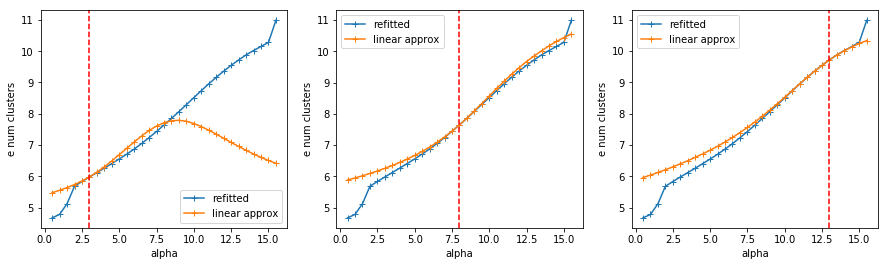

In [10]:
f, axarr = plt.subplots(1, 3, figsize = (15, 4))

axarr[0].plot(alpha_list, refit_e_num_clusters_vec_init3, '+-')
axarr[0].plot(alpha_list, lr_e_num_clusters_vec_init3, '+-')
axarr[0].set(xlabel='alpha', ylabel='e num clusters')
axarr[0].legend(('refitted', 'linear approx'))
axarr[0].axvline(3.0, color = 'red', linestyle = 'dashed')

axarr[1].plot(alpha_list, refit_e_num_clusters_vec_init8, '+-')
axarr[1].plot(alpha_list, lr_e_num_clusters_vec_init8, '+-')
axarr[1].set(xlabel='alpha', ylabel='e num clusters')
axarr[1].legend(('refitted', 'linear approx'))
axarr[1].axvline(8.0, color = 'red', linestyle = 'dashed')

axarr[2].plot(alpha_list, refit_e_num_clusters_vec_init13, '+-')
axarr[2].plot(alpha_list, lr_e_num_clusters_vec_init13, '+-')
axarr[2].set(xlabel='alpha', ylabel='e num clusters')
axarr[2].legend(('refitted', 'linear approx'))
axarr[2].axvline(13.0, color = 'red', linestyle = 'dashed')

For other parametric sensitivty figures, set `threshold` and/or `insample` flag accordingly. 